In [282]:
import os
import argparse
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull
from datetime import datetime
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore,spearmanr
from scipy import stats
import itertools

In [59]:
# For reproducibility.  when running gridsearch or 50 subsample, set to None to measure stochasticity
seed_value = False

# 1. Config

In [61]:
# Set configuration
toy=False
sample = 0 #which random subsample to run, this will be replaced by command line arguments
pre_or_post = 'pre' #see README
plot=False
timestamp = datetime.today().strftime('%Y-%m-%d-%H-%M')
data_folder = './../../datum/reddit/input/final_features/'
output_dir = f'./../../datum/reddit/output/supervised_umap/umap_cluster_{pre_or_post}_{timestamp}/'
print(output_dir)

./../../datum/reddit/output/supervised_umap/umap_cluster_pre_2020-06-29-18-20/


In [62]:
# # # Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/' #when running on Google Drive


In [63]:
try: os.mkdir(output_dir)
except: pass

In [60]:

def str2boolean(s):
	if s == 'False':
		s_new = False
	else:
		s_new = True
	return s_new

In [64]:
# Or load from arguments to run on cluster 
try: 
    parser = argparse.ArgumentParser()
    parser.add_argument('--job_array_task_id',
                        help='default: ${SLURM_ARRAY_TASK_ID} or 1. When using job arrays, this will be set by the bash script by ${SLURM_ARRAY_TASK_ID} or set to 1, which will be substracted below by 1 for zero indexing')
    parser.add_argument('--plot', help='plot of each run')
    parser.add_argument('--toy', help='run quickly with less labels, parameters and splits')
    parser.add_argument('--pre_or_post', help='post, pre, 2019, 2018')

    args = parser.parse_args()
    if args.job_array_task_id != None:
        sample = int(args.job_array_task_id) - 1

    if args.plot!=None:
        plot = str2boolean(args.plot)

    if args.toy!=None:
        toy = str2boolean(args.toy)

    if args.toy!=None:
        pre_or_post = str(args.pre_or_post)
except: 
    print('Did not load argparse')
    pass
    

In [67]:
subreddits = ['EDAnonymous',
 'addiction',
 'adhd',
 'alcoholism',
 'anxiety',
 'autism',
 'bipolarreddit',
 'bpd',
 'depression',
 'healthanxiety',
 'lonely',
 'ptsd',
 'schizophrenia',
 'socialanxiety',
 'suicidewatch']

print(len(subreddits))

15


# 2. Functions

In [86]:
# silence NumbaPerformanceWarning from UMAP
import warnings
import numba
from numba.errors import NumbaPerformanceWarning

warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)


In [87]:
import pickle
def save_obj(obj, path ):
    with open(path , 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return a[p], b[p], c[p]

In [88]:
def scatter_plot(X_reduced, y, color_code, method, annotate = False,title = 'title', savefig_path = False,
                 centers= None, centers_labels = None,  plot_centroid_names = True, dists=None):

    plt.clf()
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
    palette =   sns.color_palette("husl", len(np.unique(y)))
    # Shuffle
    X_reduced, y, color_code = unison_shuffled_copies(X_reduced, y, color_code)
    
    data = pd.DataFrame(X_reduced, columns = ['x', 'y'])
    data['label'] = y
    color_order = np.unique(y)
    print(color_order)
    if centers_labels:
        legend=False
    else:
        legend=True
    g = sns.lmplot(data=data, x='x', y='y', hue='label', hue_order=color_order,
                   fit_reg=False, legend=legend,palette=palette, legend_out=True, scatter_kws={"s": 10})
    
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]), fontsize = 12)

    # Centroids
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=10, marker='x',
        c='magenta', edgecolor='black')
    
    if centers_labels and plot_centroid_names:
        for i, label in enumerate(centers_labels):
            plt.text(x = centers[i,0], y = centers[i,1], s=label, fontsize=8)
    
    if title:
        plt.title(title)
        
    plt.ylabel('UMAP 2')
    plt.xlabel('UMAP 1')
    
    if savefig_path:
        print('plotting...')
        plt.savefig(savefig_path+title.replace('/','-')+'.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [69]:
def run_umap(X=None, y=None, method = 'unsupervised', scaler=None, neighbor = 10, dist=0.1, metric='correlation', 
             color_code = None, annotate_names = None, annotate = False, test_set = True, title=None, 
             savefig_path = False, X_test=None, y_test=None, color_code_test = None, plot=True, plot_centroid_names = True):
    
    reducer = umap.UMAP(n_components=dimension, n_neighbors = neighbor, min_dist=dist,metric=metric,random_state=seed_value) #, TSNE(n_components=k, random_state=seed_value), PCA(n_components=k, random_state=seed_value)]
    reducer_name = 'umap' #, 'tsne', 'pca']

    pipeline = Pipeline([
        ('normalization', scaler),
        ('reducer', reducer), ])

    y_encoded = LabelEncoder().fit_transform(y)
    if method == 'supervised':
        X_reduced = pipeline.fit_transform(X, y_encoded)
    elif method == 'metric_learning':
        X_reduced = pipeline.fit_transform(X, y_encoded)
        X_reduced_test = pipeline.transform(X_test)
        
    elif method == 'unsupervised':
        X_reduced = pipeline.fit_transform(X)

    # find centroids and labels
    data = pd.DataFrame(X_reduced, columns = ['x1', 'x2'])
    data['label'] = y

    centers = []
    centers_labels = list(np.unique(y))
    for sr in centers_labels:
        data_sr = data[data.label==sr]
        sr_centroid = data_sr[['x1','x2']].mean(axis=0)
        centers.append(sr_centroid)
    
    centers = np.array(centers)
    
    
    # Plot in 2D
    if plot:
        assert dimension == 2 
        if method == 'metric_learning':
            # train: first time point
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = 'First time step (train set)', savefig_path = savefig_path )
            # test: next time points            
            scatter_plot(X_reduced_test, y_test, color_code_test, method, annotate = annotate, title = title, savefig_path = savefig_path)
            
        else:
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = title, savefig_path = savefig_path, centers=centers, centers_labels = centers_labels,plot_centroid_names = plot_centroid_names )
    if method == 'metric_learning':
        return X_reduced, X_reduced_test
    else:
        return X_reduced, centers, centers_labels

def scatter_X_reduced(X_reduced, color_code, annotate_names):
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color_code, alpha=0.8, s=6)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))
    plt.show()
    
    
def gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat):
    gridsearch  = []
    for metric in metrics:
        for neighbor in n_neighbors:
            for dist in min_dist:
                for dimension in n_dimensions:
                    for scaler in scalers:
                        for r in repeat:
                            gridsearch.append([metric,neighbor,dist,dimension,scaler, r])
    return gridsearch

In [70]:
def subsample_df(df, subsample):
	if type(subsample) == float:
		subsample = int(df.shape[0]*subsample)
	df = df.reset_index(drop=True)
	df2 = df.loc[np.random.choice(df.index,subsample, replace=False)]
	return df2


In [89]:
def clean(df):
    # remove author duplicates and shuffle so we dont keep only first posts in time
    reddit_data = df.sample(frac=1) #shuffle
    reddit_data = reddit_data.drop_duplicates(subset='author', keep='first')
    reddit_data  = reddit_data [~reddit_data.author.str.contains('|'.join(['bot', 'BOT', 'Bot']))] # There is at least one bot per subreddit
    reddit_data = reddit_data[~reddit_data.post.str.contains('|'.join(['quote', 'QUOTE', 'Quote']))] # Remove posts in case quotes are long
    reddit_data = reddit_data.reset_index(drop=True)
    return reddit_data


def load_reddit(subreddits, data_folder='./', subsample = 5600,pre_or_post = 'pre'):
    # subsample = 5600 #False, int for balanced, or 0.1 for unbalanced proportion, 5600
    # Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
    subreddits.sort()
    # Main features
    # Load first subreddit to build DF
    reddit_data = pd.read_csv(data_folder+subreddits[0]+'_{}_features_tfidf_256.csv'.format(pre_or_post), index_col=False)        
    #     Clean
    reddit_data = clean(reddit_data)
    # remove jan and feb data from covid19_support because there's not enough data and if not kmeans will assign two centroids to another larger subreddit
    days = np.unique(reddit_data.date)
    days_jan_feb = [n for n in days if '2020/01' in n or '2020/02' in n]
    days_jan_feb
    if subreddits[0]=='COVID19_support' and pre_or_post == 'post':
        reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]

    # Subsample to int or subsample float
    print(reddit_data.shape)
    if subsample and subreddits[0] !='COVID19_support':
        reddit_data = subsample_df(reddit_data, subsample)
        print(reddit_data.shape)

    # Add next subreddits
    for i in np.arange(1, len(subreddits)):
        print('===')
        print(subreddits[i])
        new_data = pd.read_csv(data_folder +subreddits[i]+'_{}_features_tfidf_256.csv'.format(pre_or_post), index_col=False)
        # Clean
        new_data  = clean(new_data )
        if subreddits[i]=='COVID19_support' and pre_or_post == 'post':
              reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]
        print(new_data.shape)
        if subsample and subreddits[i] !='COVID19_support':
            new_data = subsample_df(new_data, subsample)
            print(new_data.shape)
        reddit_data = pd.concat([reddit_data, new_data], axis=0)

    return reddit_data



In [73]:
from scipy.spatial.distance import directed_hausdorff, euclidean


def hausdorff_distances(X,y, labels):
    # directed or assymetric variant     
    len_labels = len(labels)
    # build empty df
    pairwise_distances_hausdorff = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)
    # pairwise_distances_euclidean = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)                          

    # Build df out of X
    df = pd.DataFrame(X)
    df.columns = ['x1', 'x2']
    df['label'] = y

    # Compute pairwise distance between labelled arrays 
    for row in range(len_labels):
        for col in range(len_labels):
            label_a = labels[row]
            label_b = labels[col]
            label_a_values = df[df.label==label_a][['x1','x2']].values
            label_b_values = df[df.label==label_b][['x1','x2']].values
            dist_hausdorff = directed_hausdorff(label_a_values,label_b_values)
            pairwise_distances_hausdorff.iloc[row,col]= dist_hausdorff[0]
    #         dist_euclidean = euclidean(label_a_values.mean(axis=0),label_b_values.mean(axis=0))
    #         pairwise_distances_euclidean.iloc[row,col]= dist_euclidean


    return pairwise_distances_hausdorff

# 3. Measure stochasticity of UMAP and subsampling

## Run umap hyperparameter tuning (optimize on silhouette score) 
## Then run 50 samples on  2019 data (set `hyperparameter_tuning` to `False`)

In [50]:
# I downloaded this script as .py and ran on cluster.  

In [ ]:
# Config
hyperparameter_tuning = False # If False, then run 50 samples on 2019 data
method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
annotate = False #each data point can be annotated
annotate_names = False 
color_code = y.copy() #color code 2D representation by subreddit label

if hyperparameter_tuning:
    # Set up gridsearch
    n_dimensions =  [4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors = [50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
    min_dist = [0,0.1,0.5,0.99] # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
    metrics = ['euclidean','cosine'] 
    repeat_n = 1
    repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
    scalers = [StandardScaler()]

else:
    # set parameters that had the highest silhouette score     
    # this will run once and output results. Run the whole script N times for N bootstrapping sample       
    n_dimensions =  [2,] 
    n_neighbors = [200] 
    min_dist = [0]
    metrics = ['cosine'] 
    repeat_n = 1
    repeat = [1]*repeat_n
    bootstrap_samples = 50
    scalers = [StandardScaler()]

In [74]:
# Load data
if pre_or_post == 'post':
    # Jan-April 2020
    subsample = 1350 #can set to False
    subreddits_edited = subreddits.copy()

elif pre_or_post == 'pre':
    # all of 2019
    subsample = 2700
    subreddits_edited = subreddits.copy()

elif pre_or_post == '2019':
    # jan-april 2019     
    subsample = 900
    subreddits_edited = subreddits.copy()

elif pre_or_post == '2018':
    # jan-april 2018
    subsample = 450
    subreddits_edited = subreddits.copy()
    subreddits_edited.remove('EDAnonymous') #this one didn't exist in 2018

# create a list from which to choose sample name
sample_names = [f'{subsample}_{n}' for n in range(bootstrap_samples)]

if toy:
    subsample = 20
    repeat_n = 2
    sample_sizes = [subsample] * repeat_n
    sample_names = [f'{subsample}_{n}' for n in range(repeat_n)]
    
#  sample is defined through jobid from argparse 
name = sample_names[sample]
savefig_path = output_dir+f'run_{name}_'


In [ ]:
# Load data
# Each time this loads, there is a new rand subsample
reddit_data = load_reddit(subreddits_edited, data_folder=data_folder, subsample = subsample,pre_or_post = pre_or_post)
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
X = reddit_data[features].values
y = reddit_data.subreddit.values

In [19]:
results = {}
results_i = []
results_i_dists = [] #euclidean
results_i_dists_hausdorff = []
results_i_centers = []

gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
    print('\n{} out of {}'.format(j, len(gridsearch)))
    print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
    title = '{}_metric_{}_neighbor_{}_dist'.format(metric,neighbor,dist) #title for plot and filename
    print('running umap...')         
    X_reduced, centers, centers_labels  = run_umap(X = X, y = y, method = method, scaler=  scaler, 
                                                   neighbor = neighbor , dist=dist, metric=metric, 
                                                   color_code = color_code, annotate_names = annotate_names, 
                                                   annotate = annotate, title=title,
                                                   savefig_path = savefig_path, plot = plot)

    print('runnning metrics...')
    
    # compute euclidean distances
    dists = euclidean_distances(centers)
    dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
    # hausdorff distance
    
    dists_df_hausdorff = hausdorff_distances(X_reduced,y, subreddits)
    # Compute silhouette score
    sil_score = silhouette_score(X_reduced, y)
    
    # centers
    df_centers = pd.DataFrame(centers)
    df_centers['labels'] = centers_labels     

    # Compute convex hull
    hull = ConvexHull(centers)
    hull_area = hull.volume #volume is area in 2D
    
    #     Append
    results_i.append([metric,neighbor,dist,sil_score, hull_area])
    results_i_dists.append(dists_df)
    results_i_dists_hausdorff.append(dists_df_hausdorff)
    results_i_centers.append(df_centers)


# general results
results_gs = pd.DataFrame(results_i)
results_gs.columns = ['metric', 'neighbor','dist', 'sil_score','convexhull']
results_gs = results_gs.sort_values('sil_score')
timestamp = datetime.now().isoformat()
results_gs.to_csv(output_dir+f'run_{name}_umap_gs_params_scores_{timestamp}.csv')

# euclidean
results_gs_dists = pd.concat(results_i_dists)
results_gs_dists.to_csv(output_dir+f'run_{name}_umap_gs_dists_{timestamp}.csv', )

# hausdorff
results_gs_dists_hausdorff = pd.concat(results_i_dists_hausdorff)
results_gs_dists_hausdorff.to_csv(output_dir+f'run_{name}_umap_gs_dists_hausdorff_{timestamp}.csv', )

# centers
results_gs_centers = pd.concat(results_i_centers)
results_gs_centers.to_csv(output_dir+f'run_{name}_umap_gs_centers_{timestamp}.csv', )
print('done.')

# 4. See how stable UMAP is across 50 runs on 2019 (pre) samples and output results

In [75]:
# Run above or load if you ran on cluster 

# Config
input_dir = output_dir.copy() # for me: './../../datum/reddit/output/supervised_umap/umap_cluster_pre_2020-06-20-09-18/'
create_2019_gif = False #not in manuscript
create_heatmap_median_iqr = True # not in manuscript


In [77]:
# Visually inspect how much they're moving: create a gif - 2019 samples if you saved png for each
import imageio

if create_2019_gif:
    frame_dur = 1.5
    filenames = os.listdir(input_dir)
    filenames = [n for n in filenames if '.png' in n ][::5]
    images = list(map(lambda filename: imageio.imread(input_dir+filename), filenames))
    imageio.mimsave(input_dir+'supervised_umap.gif', images, format='GIF', duration=frame_dur)

In [78]:
# Load pairwise distances for all 50 runs to compute median and iqr 


dists_all = []
ranked_index = []
files = os.listdir(input_dir)
files = [n for n in files if '_dists_hausdorff_' in n ]
for file in files:
    df = pd.read_csv(input_dir+file, index_col=0)
    df = df.sort_index()
    df = df.reindex(sorted(df.columns), axis=1)
    if len(np.unique(df.index)) < len(df.index):
        break
    dists_all.append(df.values)
    
    df_mean_ranked = df.mean()
    df_mean_ranked = df_mean_ranked.sort_values(0)
    df_mean_ranked_index = list(df_mean_ranked.index)
    ranked_index.append(df_mean_ranked_index)

dists_all = np.array(dists_all)

In [94]:
# Median
df_median = np.median(dists_all, axis=0)
df_median = pd.DataFrame(df_median)
df_median.columns = subreddits_new
df_median.index = subreddits_new
print('max:', df_median.max().max())

max: 29.041715006246807


In [93]:
from scipy.stats import iqr
# IQR
df_iqr = iqr(dists_all, axis=0)
df_iqr = pd.DataFrame(df_iqr)
df_iqr.columns = subreddits_new
df_iqr.index = subreddits_new
print('max:', df_iqr.max().max())

max: 21.08471434571117


In [83]:
# Sort by sum of IQR 
sorted_iqr = list((df_iqr+df_iqr.T).sum().sort_values().index)

def reorder_index_cols(df, ordered_list):
    df = df.reindex(ordered_list)
    df = df[ordered_list]
    return df
    
df_median = reorder_index_cols(df_median, sorted_iqr)
df_iqr = reorder_index_cols(df_iqr, sorted_iqr)




In [90]:
# Add original sample size from which they were subsampled to sr name
# reddit_data = load_reddit(subreddits, data_folder=data_folder + 'final_features/', subsample = False,pre_or_post = 'pre')

count = {}
for sr in subreddits:
    count_sr = reddit_data[reddit_data.subreddit==sr].shape[0]
    count[sr]=str(np.round(count_sr/1000,1))+'k'
    
# Append original sample size to subreddit name
subreddits_new = []
for sr in subreddits:
    name_new = sr+' '+count.get(sr)
    subreddits_new.append(name_new)

<Figure size 9000x4500 with 0 Axes>

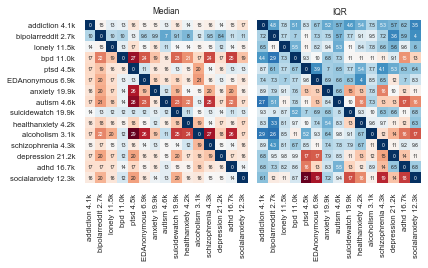

In [92]:
# Heatmap
sns.set(font_scale=0.7)
fontsize = 5
plt.figure(figsize=(30,15), dpi= 300, facecolor='w', edgecolor='k')
f, axes = plt.subplots(1, 2, sharey=True)

# plt.subplot(1, 2, 1)
ax = sns.heatmap(df_median, ax=axes[0],cmap = 'RdBu_r', annot=True,annot_kws={"fontsize":fontsize}, cbar=False)

axes[0].title.set_text('Median')
axes[0].set(adjustable='box', aspect='equal')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# plt.subplot(1, 2, 2)
ax = sns.heatmap(df_iqr, ax=axes[1], cmap = 'RdBu_r', annot=True, annot_kws={"fontsize":fontsize},cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
axes[1].title.set_text('IQR')
axes[1].set(adjustable='box', aspect='equal')
plt.tight_layout()
plt.savefig(input_dir+'heatmap_dists.png', dpi=300)


# 5. 2020 (post) data: Build X, y by grouping data by timestep (e.g., 15 days) and run UMAP. 

## 5.1. Bootstrap this 50 times.

In [ ]:
output_dir = input_dir.replace('pre', 'post') #We're running for 2020 (post) data
try: os.mkdir(output_dir)
except: pass

# Random subsampling may create reproducibility problems, so bootstrap it
subsample = 1300
timestep = 15
bootstrap_samples = 50
run_2020_bootstrap = False # It will take a while

In [202]:
if run_2020_bootstrap:
    X_all = []
    y_all = []
    for sample in range(bootstrap_samples):
        print(f'==========bootstrap {sample}')
        X = [] #shape (weeks, posts balanced by subreddits except COVID19_support, features)
        y = []
        # Subsample data         
        reddit_data = load_reddit(subreddits, data_folder=data_folder+'final_features/', subsample = subsample,pre_or_post = 'post')
        features = list(reddit_data.columns)
        features = [n for n in features if n not in ['subreddit','author','date','post']]
        for i in range(0,len(days),timestep)[:-1]: #remove last window cause it will have < days than other time windows
            days_week = days[i:i+timestep]
            df_week = reddit_data[reddit_data.date.isin(days_week)]
            df_week_feature_cols = df_week[features].values #filter features
            df_week_y = list(df_week.subreddit)
            days = np.unique(reddit_data.date)
            X.append(df_week_feature_cols)
            y.append(df_week_y)
        X_all.append(X)
        y_all.append(y)

    X_timesteps_all = np.array(X_all)
    y_timesteps_all = np.array(y_all)
    days_week = days[::timestep]
    np.save(output_dir+'X_timesteps_all.npy',X_timesteps_all)
    np.save(output_dir+'y_timesteps_all.npy',y_timesteps_all)

==========bootstrap 0
(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholism
(1424, 350)
(1300, 350)
===
anxiety
(15862, 350)
(1300, 350)
===
autism
(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healthanxiety
(2419, 350)
(1300, 350)
===
lonely
(7937, 350)
(1300, 350)
===
ptsd
(2052, 350)
(1300, 350)
===
schizophrenia
(1858, 350)
(1300, 350)
===
socialanxiety
(3728, 350)
(1300, 350)
===
suicidewatch
(21363, 350)
(1300, 350)
===day 0
===day 15
===day 30
===day 45
===day 60
===day 75
===day 90
==========bootstrap 1
(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholism
(1424, 350)
(1300, 350)
===
anxiety
(15862, 350)
(1300, 350)
===
autism
(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healt

(2052, 350)
(1300, 350)
===
schizophrenia
(1858, 350)
(1300, 350)
===
socialanxiety
(3728, 350)
(1300, 350)
===
suicidewatch
(21363, 350)
(1300, 350)
===day 0
===day 15
===day 30
===day 45
===day 60
===day 75
===day 90
==========bootstrap 13
(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholism
(1424, 350)
(1300, 350)
===
anxiety
(15862, 350)
(1300, 350)
===
autism
(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healthanxiety
(2419, 350)
(1300, 350)
===
lonely
(7937, 350)
(1300, 350)
===
ptsd
(2052, 350)
(1300, 350)
===
schizophrenia
(1858, 350)
(1300, 350)
===
socialanxiety
(3728, 350)
(1300, 350)
===
suicidewatch
(21363, 350)
(1300, 350)
===day 0
===day 15
===day 30
===day 45
===day 60
===day 75
===day 90
==========bootstrap 14
(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholis

(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healthanxiety
(2419, 350)
(1300, 350)
===
lonely
(7937, 350)
(1300, 350)
===
ptsd
(2052, 350)
(1300, 350)
===
schizophrenia
(1858, 350)
(1300, 350)
===
socialanxiety
(3728, 350)
(1300, 350)
===
suicidewatch
(21363, 350)
(1300, 350)
===day 0
===day 15
===day 30
===day 45
===day 60
===day 75
===day 90
==========bootstrap 26
(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholism
(1424, 350)
(1300, 350)
===
anxiety
(15862, 350)
(1300, 350)
===
autism
(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healthanxiety
(2419, 350)
(1300, 350)
===
lonely
(7937, 350)
(1300, 350)
===
ptsd
(2052, 350)
(1300, 350)
===
schizophrenia
(1858, 350)
(1300, 350)
===
socialanxiety
(3728, 350)
(1300, 350)
===
suicidewatch
(2

(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholism
(1424, 350)
(1300, 350)
===
anxiety
(15862, 350)
(1300, 350)
===
autism
(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healthanxiety
(2419, 350)
(1300, 350)
===
lonely
(7937, 350)
(1300, 350)
===
ptsd
(2052, 350)
(1300, 350)
===
schizophrenia
(1858, 350)
(1300, 350)
===
socialanxiety
(3728, 350)
(1300, 350)
===
suicidewatch
(21363, 350)
(1300, 350)
===day 0
===day 15
===day 30
===day 45
===day 60
===day 75
===day 90
==========bootstrap 39
(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholism
(1424, 350)
(1300, 350)
===
anxiety
(15862, 350)
(1300, 350)
===
autism
(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healthanxiety
(2419, 350)


In [98]:
# Run above or load:
X_timesteps_all = np.load(output_dir+'X_timesteps_all.npy', allow_pickle=True) #2.58 GB
y_timesteps_all = np.load(output_dir+'y_timesteps_all.npy', allow_pickle=True)
reddit_data = load_reddit(subreddits, data_folder=data_folder+'final_features/', 
                          subsample = subsample,pre_or_post = 'post') 


In [143]:
timesteps

7

In [148]:
days = np.unique(reddit_data.date)
timestep = 15
days_week = days[::timestep]
timesteps = days_week[:-1]

In [150]:
# Describe sample size depending on timewindow
print(f'days: {len(days)}')
windows = len(days)/timestep
print(f'windows: {windows}')
print(f'timesteps: {timesteps}')
print(f'days per timestep: {timestep}')
print(f'samples per subreddit per timestep: {1300/windows}')

days: 111
windows: 7.4
timesteps: ['2020/01/01' '2020/01/16' '2020/01/31' '2020/02/15' '2020/03/01'
 '2020/03/16' '2020/03/31']
days per timestep: 15
samples per subreddit per timestep: 175.67567567567568


## 5.2. For each bootstrapping sample, perform UMAP and measure distances for each timestep

In [204]:
# Config
run_2020_umap = False # This will take a while
plot = False
savefig_path = output_dir

In [205]:
if run_2020_umap:
    method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
    plot_centroid_names=True
    annotate = False
    annotate_names = False
    run_Ntimesteps = len(X_timesteps)# len(X)#len(X) #1,2 ... len(X) 

    # Set up gridsearch or final parameters set
    n_dimensions =  [2,] #4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors = [200] #[50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
    min_dist = [0]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
    metrics = ['cosine'] #,'cosine'] # cosine adds points?
    repeat_n = 1
    repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
    scalers = [StandardScaler()]
    gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
    name = subsample

    hausdorff_all = []

    # For each bootstrapping sample, reduce dimensionality (optional: plot), compute hausdorff distance
    for all_i, (X_timesteps, y_timesteps) in enumerate(zip(X_timesteps_all, y_timesteps_all)):
        results_i_dists_hausdorff = []

        features = list(reddit_data.columns)
        features = [n for n in features if n not in ['subreddit','author','date','post']]
        for i, (X_i, y_i) in enumerate(zip(X_timesteps[:run_Ntimesteps],y_timesteps[:run_Ntimesteps])):
            print('\n{} out of {}'.format(i, run_Ntimesteps))
            start_day = days_week[i].replace('/', '-')
            start_day = f'{start_day}'
            color_code = y_i.copy()

            for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
                title = f'{all_i}_{start_day}'.replace('-','/')
                print('running umap...')         
                X_reduced, centers, centers_labels  = run_umap(X = X_i, y = y_i, method = method, scaler=  scaler, 
                                                               neighbor = neighbor , dist=dist, metric=metric, 
                                                               color_code = color_code, annotate_names = annotate_names, 
                                                               annotate = annotate, title=title,
                                                               savefig_path = savefig_path, plot = plot, 
                                                               plot_centroid_names=plot_centroid_names)

                # hausdorff distance
                dists_df_hausdorff = hausdorff_distances(X_reduced,y_i, subreddits)
                results_i_dists_hausdorff.append(dists_df_hausdorff.values)

        hausdorff_all.append(results_i_dists_hausdorff)


    hausdorff_all = np.array(hausdorff_all)

    # hausdorff
    np.save(output_dir+f'run_{name}_hausdorff_all.npy',hausdorff_all)
    print('done.')


0 out of 7
running umap...
running kmeans...

1 out of 7
running umap...
running kmeans...

2 out of 7
running umap...
running kmeans...

3 out of 7
running umap...
running kmeans...

4 out of 7
running umap...
running kmeans...

5 out of 7
running umap...
running kmeans...

6 out of 7
running umap...
running kmeans...

0 out of 7
running umap...
running kmeans...

1 out of 7
running umap...
running kmeans...

2 out of 7
running umap...
running kmeans...

3 out of 7
running umap...
running kmeans...

4 out of 7
running umap...
running kmeans...

5 out of 7
running umap...
running kmeans...

6 out of 7
running umap...
running kmeans...

0 out of 7
running umap...
running kmeans...

1 out of 7
running umap...
running kmeans...

2 out of 7
running umap...
running kmeans...

3 out of 7
running umap...
running kmeans...

4 out of 7
running umap...
running kmeans...

5 out of 7
running umap...
running kmeans...

6 out of 7
running umap...
running kmeans...

0 out of 7
running umap...
runnin

running kmeans...

4 out of 7
running umap...
running kmeans...

5 out of 7
running umap...
running kmeans...

6 out of 7
running umap...
running kmeans...

0 out of 7
running umap...
running kmeans...

1 out of 7
running umap...
running kmeans...

2 out of 7
running umap...
running kmeans...

3 out of 7
running umap...
running kmeans...

4 out of 7
running umap...
running kmeans...

5 out of 7
running umap...
running kmeans...

6 out of 7
running umap...
running kmeans...

0 out of 7
running umap...
running kmeans...

1 out of 7
running umap...
running kmeans...

2 out of 7
running umap...
running kmeans...

3 out of 7
running umap...
running kmeans...

4 out of 7
running umap...
running kmeans...

5 out of 7
running umap...
running kmeans...

6 out of 7
running umap...
running kmeans...

0 out of 7
running umap...
running kmeans...

1 out of 7
running umap...
running kmeans...

2 out of 7
running umap...
running kmeans...

3 out of 7
running umap...
running kmeans...

4 out of 7
runn

# 6. Visually inspect changes in 2020 distance with regards to 2019 fluctuations in distances

In [116]:
# Either re-run above or load here
output_dir='./../../datum/reddit/output/supervised_umap/umap_cluster_post_2020-06-20-09-18/'
hausdorff_all = np.load(output_dir+'run_1300_hausdorff_all.npy')


In [118]:
print('bootsrapping sample, timestep, subreddits, subreddits')
hausdorff_all.shape

bootsrapping sample, timestep, subreddits, subreddits


(50, 7, 15, 15)

## 6.0. (ERASE) Visually inspect which subreddits are becoming closer with a line 
(this won't be useful statistically because there are only 7 timesteps to fit the line, but it's good for inspection)
(erase: was only done for one sample, not bootstrapping samples)

In [176]:
# Or fit a polynomial
def polyfit(x, y, degree):
    results = {}

    coeffs = numpy.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = numpy.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [209]:

# x = np.array([0.0, 1.0, 2.0, 3.0,  4.0,  5.0])
# y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0])
# degree = 3

# df = pd.DataFrame(columns=['y', 'x'])
# df['x'] = x
# df['y'] = y

# weights = np.polyfit(x, y, degree)
# model = np.poly1d(weights)
# results = smf.ols(formula='y ~ model(x)', data=df).fit()
# results.summary()

In [210]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf


<Figure size 1200x1200 with 0 Axes>

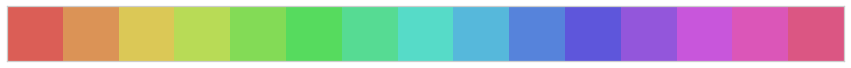

EDAnonymous


NameError: name 'results_i_dists_hausdorff' is not defined

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [120]:
polynomial = False
savefig =True
try: os.mkdir(output_dir+'trends/')
except: pass


sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(15,15), dpi= 80, facecolor='w', edgecolor='k')




results_slope = {}
for sr_title in subreddits:
    results_slope[sr_title] = []
    
results_p_value = {}
for sr_title in subreddits:
    results_p_value[sr_title] = []
    
# todo: add text in plot

color = 'hls' #hls husl
palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
sns.palplot(sns.color_palette(color, len(subreddits)))
plt.show()

for i, sr_title in enumerate(subreddits):
    print(sr_title)
    plt.clf()
    plt.figure()
    for j,sr_line in enumerate(subreddits):
        x = days_week[:-1] #last window is removed becuase < timestep
        x_digits = range(len(x))
        y = results_i_dists_hausdorff[:,j,i]
        y = zscore(y)
        if polynomial:
            if str(y[0]) =='nan':
                r_value, p_value = np.nan, np.nan
                continue
            df = pd.DataFrame(columns=['y', 'x'])
            df['x'] = x_digits
            df['y'] = y
            weights = np.polyfit(x_digits, y, polynomial) #polynomial=degree
            model = np.poly1d(weights)
            results = smf.ols(formula='y ~ model(x)', data=df).fit()
            p_value = results.pvalues[1]
            r2 = results.rsquared
            summary = results.summary()
        else:
            # linear             
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)            
            sns.lineplot(x, x_digits*slope + intercept, label = sr_line, color=next(palette))
            sns.lineplot(x, y,alpha=0.2)
            results_slope[sr_title].append(slope * r_value**2)
            results_p_value[sr_title].append(p_value)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title( sr_title)
    plt.xlabel('time')
    plt.xticks(rotation=70)
    plt.ylim((-2,2))
    plt.ylabel('Hausdorff distance (z-score)')
    if savefig:
        plt.tight_layout()
        plt.savefig(output_dir+f'/trends/{sr_title}.png', dpi=300)
    plt.show()

Here I tried to measure significance of slope but then realized there are only 7 timesteps, won't be significant after multiple comparison correction

In [212]:
# # Make DFs
# results_slope
# df_slope_r2 = pd.DataFrame(results_slope)
# df_slope_r2.index = subreddits
# df_slope_r2.columns = subreddits
# df_p_value = pd.DataFrame(results_p_value)
# df_p_value.index = subreddits
# df_p_value.columns = subreddits
# df_p_value


In [213]:
# # Extract tril
# def extract_tril(df):
#     df_tril = np.tril(df,k=0)
#     df_tril[df_tril == 0] = np.nan
#     df_tril = pd.DataFrame(df_tril, columns=df.columns, index=df.index)
#     return df_tril

# df_p_value_tril = extract_tril(df_p_value)
# df_slope_r2_tril = extract_tril(df_slope_r2)
# df_p_value_tril
    

In [214]:
# import math
# pvals = df_p_value_tril.values.flatten()
# print(len(pvals))
# pvals = [n for n in pvals if n == n]
# print(len(pvals))

In [215]:
# reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
# np.sum(reject)

In [216]:
# def multiple_comparisons(df_slope_r2, df_p_value):   
#     pvals = df_p_value_tril.values.flatten()
#     pvals = [n for n in pvals if n == n]
    
#     # Obtain mask of non-significant results
#     pvals= df_p_value.values.flatten() 
#     reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

#     # Create mask with significant results
#     reject_opp = np.array([not c for c in reject]) #inverse mask of booleans
#     df_shape = df_p_value.shape # reshape to this shape
#     df_reject = pd.DataFrame(reject_opp.reshape(df_shape))
#     df_reject.columns = df_slope_r2.columns
#     df_reject.index = df_slope_r2.index
#     print('Significant results: ',np.sum(reject)/len(reject))
#     return df_slope, df_reject


In [217]:

# # Plot
# plt.clf()
# fontsize = 5
# plt.figure(figsize=(4,4), dpi= 150, facecolor='w', edgecolor='k')
# ax = sns.heatmap(df_slope_r2.round(2), annot=True,cmap = 'RdBu_r',vmin=-0.25, vmax=.25, cbar=False,annot_kws={"fontsize":fontsize})
# plt.xticks(rotation=90, fontsize=fontsize)
# plt.yticks(rotation=0, fontsize=fontsize)
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.tight_layout()
# plt.savefig(output_dir+'/trends/heatmap.png',dpi=300)



## 6.1. Compute percentiles with regards to 2019 pre data

In [130]:
# Choose subreddits for the example
save_fig = False # False so you don't replace already saved figs
bootstrap_samples = 50
sr_example_a = 'healthanxiety' 
sr_example_b = 'EDAnonymous'
sr_example_index = subreddits.index(sr_example_b)

In [126]:
# This is fast
distances_all = []
percentile_all = []
distribution_2019_healthanxiety_all = [] #only between two subreddits, all bootstrap samples
distances_2020_all = [] #distance for each timestep between two subreddits, all bootstrap samples

for bootstrap_i in range(bootstrap_samples):
    distance_3D_by_subreddit = [] # for 15 subreddits: pairwise distance for each timstep (15 rows and 7 timesteps)
    percentile_3D_by_subreddit = [] # same Percentiles with regards to 2019

    # To plot an example between 2 subreddits
    distribution_2019_healthanxiety = []
    distances_2020 = [] #distance for each timestep

    for sr_i in range(len(subreddits)):

        sr = subreddits[sr_i]     # eg healthanxiety     
        check = sr
        # create df where I insert the distance 
        distance_df_sr = np.zeros(hausdorff_all[0].shape[:2]).T # shape (timesteps,15)
        # create df where I insert what percentile the distance is with regards to 2019 data     
        percentile_df_sr = np.zeros(hausdorff_all[0].shape[:2]).T # shape (timesteps,15)
        for timestep_i, timestep_df in enumerate(hausdorff_all[bootstrap_i]):
            # timestep_df has shape (15,15), pairwise dist for 1 timestep
            distances_sr = timestep_df[:,sr_i] #extract distances between this sr and other ones, the same as [sr_i, :] cause it's symmetrical
            for distance_i in range(len(distances_sr)):   
                distance_2020 = distances_sr[distance_i]             
                distance_df_sr [distance_i,timestep_i] = distance_2020
                #             
                distribution_2019 = dists_all[:,distance_i,sr_i]
                percentile = stats.percentileofscore(distribution_2019, distance_2020)
                percentile_df_sr [distance_i,timestep_i] = percentile        
                if  sr == sr_example_a and distance_i == sr_example_index:
                    # For example plot                 
                    distances_2020.append(distance_2020)
                    distribution_2019_healthanxiety.append(distribution_2019)
        percentile_3D_by_subreddit.append(percentile_df_sr)
        distance_3D_by_subreddit.append(distance_df_sr)


    percentile_3D_by_subreddit = np.array(percentile_3D_by_subreddit)
    distances_all.append(distance_3D_by_subreddit)
    percentile_all.append(percentile_3D_by_subreddit)
    distribution_2019_healthanxiety_all.append(distribution_2019_healthanxiety)
    distances_2020_all.append(distances_2020)
    
distances_all = np.array(distances_all)
percentile_all = np.array(percentile_all)
distribution_2019_healthanxiety_all = np.array(distribution_2019_healthanxiety_all)
distribution_2019_healthanxiety = distribution_2019_healthanxiety[0] #I append it 7 times, but they're all the same
distances_2020_all = np.array(distances_2020_all)


In [127]:
# The output is     
distances_all.shape

(50, 15, 15, 7)

In [135]:
# ERASE:
add_covid19_mentions = False
# # to add to plot mention of covid19
# add_covid19_mentions = False
# covid_mean = np.array([1.37600246e-04, 9.57345045e-05, 1.19084550e-04, 1.38857552e-04,
#        1.58399398e-04, 1.46508084e-04, 1.36883143e-04, 7.28435534e-05,
#        8.05822045e-05, 1.04981156e-04, 1.99514315e-04, 3.97653861e-04,
#        8.49297062e-04, 8.82636594e-04, 6.32921459e-04, 4.41946499e-04,
#        5.12115236e-04, 3.28384094e-04, 4.61536461e-04, 3.40176205e-04,
#        4.20744113e-04, 2.27834173e-04, 4.18033059e-04, 5.03355905e-04,
#        4.41112974e-04, 1.82477636e-04, 3.91469570e-04, 3.59483858e-04,
#        6.96401914e-04, 6.60079615e-04, 1.36545814e-03, 2.53557029e-04,
#        5.30087844e-04, 3.06258723e-04, 1.10060493e-03, 1.75229626e-03,
#        3.82335341e-03, 3.54900845e-03, 4.70985334e-03, 3.59627607e-03,
#        4.07187859e-03, 3.96221607e-03, 4.53415672e-03, 3.52455265e-03,
#        3.13137661e-03, 2.71011345e-03, 3.16281317e-03, 2.79342252e-03,
#        2.83837582e-03, 2.29320931e-03, 2.45448753e-03, 2.89407344e-03,
#        2.31492345e-03, 2.16047706e-03, 2.07815072e-03, 2.13970058e-03])

# x_covid = range(8)
# y_covid = covid_mean[::7][:8]*10000
# print(len(y_covid))

In [136]:
distances_2020_all.shape

(50, 7)

In [151]:
timesteps

array(['2020/01/01', '2020/01/16', '2020/01/31', '2020/02/15',
       '2020/03/01', '2020/03/16', '2020/03/31'], dtype=object)

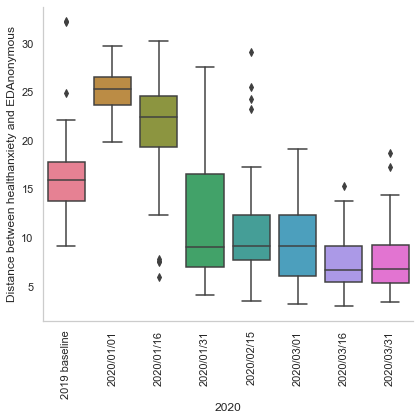

In [152]:

sns.set(rc={'figure.figsize':(6,6)}, font_scale =1, palette=sns.color_palette("husl", 7))
sns.set_style("white", {"axes.edgecolor": ".8"})

# boxplot for 2019
y = list(distribution_2019_healthanxiety) #  shape (50)
length_2019_distr = len(y)
x = ['2019 baseline']*length_2019_distr

# Add values (y) and labels (x) for different timesteps (['2020/01/01', '2020/01/16', '2020/01/31', '2020/02/15','2020/03/01', '2020/03/16', '2020/03/31'])
for i in range(len(timesteps)):
    date = timesteps[i]
    x = x + [date]*bootstrap_samples
    y = y + list(distances_2020_all[:,i]) #i is a timestep, shape (50)    

sns.boxplot(x=x,y=y, palette='husl')
sns.despine()
plt.xticks(rotation=90)
plt.xlabel('2020')
plt.ylabel(f'Distance between {sr_example_a} and {sr_example_b}')



if add_covid19_mentions:
    sns.lineplot(x=x_covid, y = y_covid, c='k')
plt.tight_layout()

if save_fig:
    plt.savefig(output_dir+'example_distance_distribution.png', dpi=400)

### Plot distances

In [153]:
# display only extreme changes
percentile_non_outliers = (percentile_all < 95) & (percentile_all > 5)
percentile_non_outliers.shape

(50, 15, 15, 7)

In [155]:


for sr in subreddits:
    x = np.array(df.timesteps)
    x_digits = np.array(range(len(x)))
    y = np.array(df[sr])
    y = zscore(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)
    pvals.append(p_value)

    if sr == 'healthanxiety':
        alpha = 1
        linewidth = 2    
    else:
        alpha = 1
        linewidth = 0.75    
    color_i = next(palette)
    ax1.plot(x, x_digits*slope + intercept, alpha=alpha, linewidth=linewidth,label = sr, color=color_i)



,2020/01/01,2020/01/16,2020/01/31,2020/02/15,2020/03/01,2020/03/16,2020/03/31
EDAnonymous,12.425319,10.579569,17.544627,17.075894,15.032999,18.508027,11.785879
addiction,12.838934,9.530902,11.672082,11.819476,15.027857,12.685767,15.693567
adhd,11.266857,10.254618,15.136664,14.649977,16.778189,16.396185,11.714459
alcoholism,20.725559,17.532672,20.360925,23.957632,18.217144,16.957581,17.193165
anxiety,10.463696,9.845803,14.271334,14.096622,13.155959,13.153594,9.349370
autism,8.151035,7.336851,11.383654,10.852735,12.345505,11.034325,8.702905
bipolarreddit,7.924194,7.502115,13.749002,10.972028,13.369056,10.629358,10.475331
bpd,8.554422,7.972993,7.301224,9.014498,6.997453,6.274972,7.767074
depression,6.630685,4.311804,7.747347,7.841126,5.895436,6.572063,7.283220
healthanxiety,14.180479,17.302008,20.734263,20.490776,17.308642,13.933426,10.426632


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


<Figure size 1000x700 with 0 Axes>

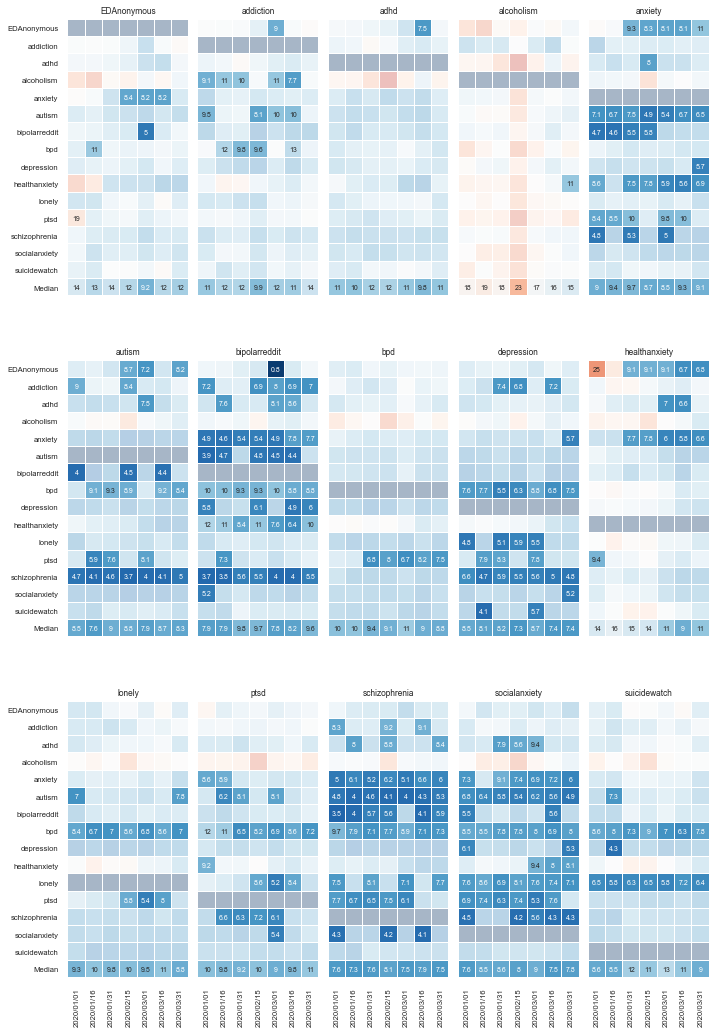

In [340]:
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color='white', alpha=0.65)

# def plot_timestep_heatmaps(df, output_filename):
sns.set(font_scale=0.7)
fontsize = 7
dpi=100
plt.figure(dpi= dpi, facecolor='w', edgecolor='k')
f, axes = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(10,15),)
axes = [n for i in axes for n in i]

median_percentiles ={}
all_percentiles = {}

for i, ax in enumerate(axes):
    print(i)

    if i in [15]:
        # If you need a blank one (4x4 grid, the 16th one or 15 with zero-index)
        df = np.ones((len(subreddits),7))
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = np.ones(7)

        hm = sns.heatmap(df, annot=False, cbar=False,cmap = 'RdBu_r',mask = np.ones(df.shape), square=True, ax=ax, annot_kws={"fontsize":fontsize})
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.set(adjustable='box', aspect='equal')
    else:
        sr = subreddits[i]
        df = pd.DataFrame(np.median(distances_all,axis=0)[i], columns = timesteps, index=subreddits)
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df_median = df.drop(index=[sr]).median()
        df.loc['Median'] = df_median
        median_percentiles[sr] = np.array(df_median.values)
        
        # save all values        
        all_percentiles[sr] = np.array(df.median().values)
        

        # define outliers         
        df_outliers = np.median(percentile_non_outliers, axis=0)[i]
        df_outliers = np.concatenate([df_outliers, [np.zeros(df.shape[1])]],axis=0)

        # keep the outliers
        sns.heatmap(df.round(1), cbar=False,cmap = cmap, square=True, ax=ax, 
                         vmin=0, vmax=35,linewidths=0)
        hm = sns.heatmap(df.round(1), annot=True, cbar=False,cmap = cmap,mask =df_outliers, square=True, ax=ax, 
                         annot_kws={"fontsize":fontsize},vmin=0, vmax=35,linewidths=0.01)
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.title.set_text(sr)
        ax.set(adjustable='box', aspect='equal')

plt.tight_layout()
if save_fig:
    plt.savefig('./../../datum/reddit/output/supervised_umap/'+f'distances_all.png', dpi=400)    
    #     plt.savefig(output_dir+f'distances_all.png', dpi=400)
    


In [ ]:
# ERASE:


# # original

# savefig = True 

# cmap = plt.get_cmap("RdBu_r")
# cmap.set_bad(color='white', alpha=0.65)

# # def plot_timestep_heatmaps(df, output_filename):
# sns.set(font_scale=0.7)
# fontsize = 6
# dpi=100
# plt.figure(dpi= dpi, facecolor='w', edgecolor='k')
# f, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,15),)
# axes = [n for i in axes for n in i]

# median_percentiles ={}

# for i, ax in enumerate(axes):
#     print(i)
#     if i in [15]:
#         df = np.ones((len(subreddits),7))
#         df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
#         df.loc['Median'] = np.ones(7)

#         hm = sns.heatmap(df, annot=False, cbar=False,cmap = 'RdBu_r',mask = np.ones(df.shape), square=True, ax=ax, annot_kws={"fontsize":fontsize})
#         bottom, top = hm.get_ylim()
#         hm.set_ylim(bottom + 0.5, top - 0.5)
#         ax.set(adjustable='box', aspect='equal')
#     else:
#         sr = subreddits[i]
#         df = pd.DataFrame(distance_3D_by_subreddit[i], columns = timesteps, index=subreddits)
#         df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
#         df.loc['Median'] = df.median()
#         median_percentiles[sr] = np.array(df.median())

#         # outliers         
#         df_outliers = percentile_non_outliers[i]
#         df_outliers = np.concatenate([df_outliers, [np.zeros(df.shape[1])]],axis=0)

        
#         sns.heatmap(df.round(1), cbar=False,cmap = cmap, square=True, ax=ax, 
#                          vmin=0, vmax=35,linewidths=0)
#         hm = sns.heatmap(df.round(1), annot=True, cbar=False,cmap = cmap,mask =df_outliers, square=True, ax=ax, 
#                          annot_kws={"fontsize":fontsize},vmin=0, vmax=35,linewidths=0.01)
#         bottom, top = hm.get_ylim()
#         hm.set_ylim(bottom + 0.5, top - 0.5)
#         ax.title.set_text(sr)
#         ax.set(adjustable='box', aspect='equal')



# plt.tight_layout()
# if savefig:
#     plt.savefig(output_dir+f'/distances_all.png', dpi=400)
    


### Plot percentiles

In [ ]:
# ERASE



# sns.set(font_scale=0.7)
# fontsize = 6
# dpi=100
# savefig  =True
# plt.figure(dpi= dpi, facecolor='w', edgecolor='k')
# f, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,15))
# axes = [n for i in axes for n in i]

# median_percentiles ={}

# for i, ax in enumerate(axes):
#     print(i)
#     if i in [15]:
#         df = np.ones((len(subreddits),7))
#         df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
#         df.loc['Median'] = np.ones(7)

#         hm = sns.heatmap(df, annot=False, cbar=False,cmap = 'RdBu_r', mask = np.ones(df.shape), square=True, ax=ax, annot_kws={"fontsize":fontsize})
#         bottom, top = hm.get_ylim()
#         hm.set_ylim(bottom + 0.5, top - 0.5)
#         ax.set(adjustable='box', aspect='equal')
#     else:
#         sr = subreddits[i]
#         df = pd.DataFrame(np.median(percentiles1 _all,axis=0)[i], columns = timesteps, index=subreddits)
#         df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
#         df.loc['Median'] = df.median()
#         median_percentiles[sr] = np.array(df.median())

#         hm = sns.heatmap(df.round(1), annot=True, cbar=False,cmap = 'RdBu_r', square=True, ax=ax, annot_kws={"fontsize":fontsize},
#                         vmin=0, vmax=100)
#         bottom, top = hm.get_ylim()
#         hm.set_ylim(bottom + 0.5, top - 0.5)
#         ax.title.set_text(sr)
#         ax.set(adjustable='box', aspect='equal')


# plt.tight_layout()
# if savefig:
#     plt.savefig(output_dir+f'/percentile_all.png', dpi=400)
    


## 6.2. Plot median changes

In [318]:
save_fig = True

In [319]:
# from sklearn import datasets, linear_model
# from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm
# from scipy import stats
# import statsmodels.formula.api as smf
# polynomial = 5
# savefig =False

#     # fit polynomial     
#     weights = np.polyfit(x_digits, y, 6) #polynomial=degree
#     model = np.poly1d(weights)
    # Obtain p-value and r2
#     df_sr = pd.DataFrame(columns=['y', 'x'])
#     df_sr['x'] = x_digits
#     df_sr['y'] = y
#     results = smf.ols(formula='y ~ model(x)', data=df_sr).fit()
#     p_value = results.pvalues[1]
#     r2 = results.rsquared
#     pvals.append(p_value)
#     r2_all.append(r2)

In [320]:
# Group covid_mean into ~16 day to make 7 windows to match here

covid_mean = np.array([1.37600246e-04, 9.57345045e-05, 1.19084550e-04, 1.38857552e-04,
       1.58399398e-04, 1.46508084e-04, 1.36883143e-04, 7.28435534e-05,
       8.05822045e-05, 1.04981156e-04, 1.99514315e-04, 3.97653861e-04,
       8.49297062e-04, 8.82636594e-04, 6.32921459e-04, 4.41946499e-04,
       5.12115236e-04, 3.28384094e-04, 4.61536461e-04, 3.40176205e-04,
       4.20744113e-04, 2.27834173e-04, 4.18033059e-04, 5.03355905e-04,
       4.41112974e-04, 1.82477636e-04, 3.91469570e-04, 3.59483858e-04,
       6.96401914e-04, 6.60079615e-04, 1.36545814e-03, 2.53557029e-04,
       5.30087844e-04, 3.06258723e-04, 1.10060493e-03, 1.75229626e-03,
       3.82335341e-03, 3.54900845e-03, 4.70985334e-03, 3.59627607e-03,
       4.07187859e-03, 3.96221607e-03, 4.53415672e-03, 3.52455265e-03,
       3.13137661e-03, 2.71011345e-03, 3.16281317e-03, 2.79342252e-03,
       2.83837582e-03, 2.29320931e-03, 2.45448753e-03, 2.89407344e-03,
       2.31492345e-03, 2.16047706e-03, 2.07815072e-03, 2.13970058e-03])
print(f'timesteps: {covid_mean.shape}')
windows = 7
timesteps_in_window = 8 #56 timesteps / 7 windows = 8 
covid_mean_7_windows = []
for i in range(windows):
    covid_mean_i = np.mean(covid_mean[i:i+timesteps_in_window])
    covid_mean_7_windows.append(covid_mean_i)
covid_mean_7_windows = zscore(covid_mean_7_windows)    

print(len(covid_mean_7_windows))

timesteps: (56,)
7


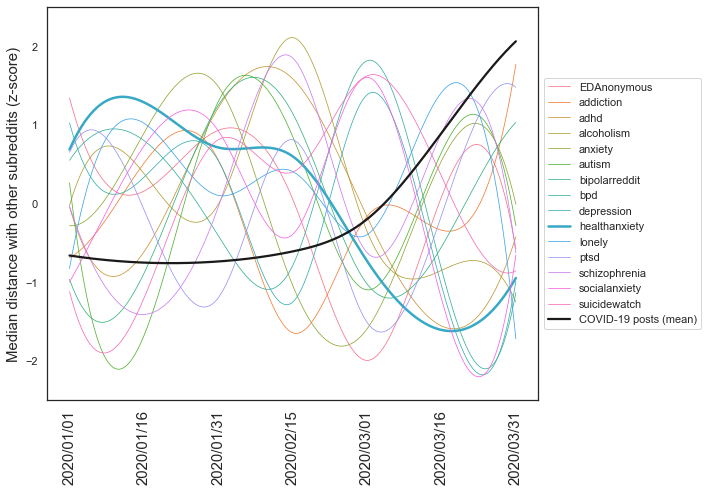

In [339]:
df = pd.DataFrame(median_percentiles)
df['timesteps'] = timesteps


color = 'husl' #hls husl
palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
sns.set(style='white', rc={'figure.figsize':(10,7)}, font_scale =1)
pvals = []
correlations_mean = []
r2_all = []
fig, ax1 = plt.subplots()
for sr in subreddits:
    x = np.array(df.timesteps)
    x_digits = np.array(range(len(x)))
    y = np.array(df[sr])
    y = zscore(y)
    # Correlation between covid19 mentions and these curves     
    c,p = spearmanr(y,covid_mean_7_windows)    
    correlations_mean.append([sr,c,p])
    # Formatting     
    color_i = next(palette)
    if sr == 'healthanxiety':
        alpha = 1
        linewidth = 2.5    
    else:
        alpha = 1
        linewidth = 0.75   
    
    # Plot raw     
    # plt.plot(x_digits,y,color=color_i, alpha=0.5, linewidth = linewidth)
    # Plot smooth
    xnew = np.linspace(np.min(x_digits), np.max(x_digits), 300)  
    spl = make_interp_spline(x_digits, y, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth, color=color_i)
    
# Plot covid19 mentions
# raw
# plt.plot(x_digits,covid_mean_7_windows, label='mean COVID19 posts',linewidth = 2.5 )
# Smooth
xnew = np.linspace(np.min(x_digits), np.max(x_digits), 300)  
spl = make_interp_spline(x_digits, covid_mean_7_windows, k=3)  # type: BSpline
power_smooth = spl(xnew)
ax1.plot(xnew,power_smooth, label='COVID-19 posts (mean)', alpha=alpha, linewidth=2.25, color='k')

ax1.set_xticks(ticks=x_digits)
ax1.set_xticklabels(x, rotation=90, fontsize=15)
plt.ylim((-2.5,2.5))
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax1.legend(loc='upper left', bbox_to_anchor=(1, 0))
# ax2.legend(loc='bottom left',prop={'size': 15}, bbox_to_anchor=(1, 0.5))
plt.ylabel('Median distance with other subreddits (z-score)', fontsize=15)
plt.xticks(rotation=90, fontsize=15)
# plt.yticks(fontsize=1.2)
plt.tight_layout()

if save_fig:
    plt.savefig(output_dir+'median_percentile_distance_curves', dpi=400)      
    


In [346]:
# Correlations between each curve and covdi19 mentions
correlations_subsample = pd.DataFrame(correlations_subsample, columns = ['subreddit','rho', 'p-value'])
correlations_mean = pd.DataFrame(correlations_mean, columns = ['subreddit','rho', 'p-value'])


In [348]:
from statsmodels.stats.multitest import multipletests
pvals = correlations_mean['p-value'].values
reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
print(reject, pvals_corrected)
correlations_mean['pvals_corrected'] =  list(pvals_corrected)
correlations_mean

[False False False False False False False False False  True False False
 False False False] [0.46875127 1.         0.80280607 0.27178847 0.80280607 1.
 1.         0.55586686 0.80280607 0.00681224 0.80280607 0.80280607
 0.87707243 0.80280607 0.80280607]


,subreddit,rho,p-value,pvals_corrected
0,EDAnonymous,-0.678571,0.093750,0.468751
1,addiction,0.071429,0.879048,1.000000
2,adhd,-0.285714,0.534509,0.802806
3,alcoholism,-0.785714,0.036238,0.271788
4,anxiety,-0.428571,0.337368,0.802806
5,autism,0.000000,1.000000,1.000000
6,bipolarreddit,-0.035714,0.939408,1.000000
7,bpd,-0.607143,0.148231,0.555867
8,depression,-0.285714,0.534509,0.802806
9,healthanxiety,-0.964286,0.000454,0.006812


In [ ]:
# df = pd.DataFrame(median_percentiles)
# df['timesteps'] = timesteps

# from statsmodels.stats.multitest import multipletests
# from scipy.interpolate import make_interp_spline, BSpline

# color = 'husl' #hls husl
# palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
# sns.set(style='white', rc={'figure.figsize':(10,7)}, font_scale =1, palette=sns.color_palette("husl", 15))
# pvals = []
# fig, ax1 = plt.subplots()
# for sr in subreddits:
#     x = np.array(df.timesteps)
#     x_digits = np.array(range(len(x)))
#     y = np.array(df[sr])
#     y = zscore(y)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)
#     pvals.append(p_value)

#     if sr == 'healthanxiety':
#         alpha = 1
#         linewidth = 2.5    
#     else:
#         alpha = 1
#         linewidth = 0.75    
#     xnew = np.linspace(np.min(x_digits), np.max(x_digits), 300)  
#     spl = make_interp_spline(x_digits, y, k=3)  # type: BSpline
#     power_smooth = spl(xnew)
#     color_i = next(palette)
#     ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth, color=color_i)

#     # add error     

# #     xnew = np.linspace(np.min(x_digits), np.max(x_digits), 300)  
# #     spl = make_interp_spline(x_digits, y_error, k=3)  # type: BSpline
# #     power_smooth = spl(xnew)
# #     color_i = next(palette)
# #     ax1.fill_between(xnew, y-sd, y+sd, alpha=alpha-0.5, color=color_i)

    
    
# #     ax1.plot(x, x_digits*slope + intercept, alpha=alpha, linewidth=linewidth,label = sr, color=color_i)

# ax1.set_xticks(ticks=x_digits)
# ax1.set_xticklabels(x, rotation=90, fontsize=15)
# plt.ylim((-2.7,2.5))


    

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylabel('Median distance with other subreddits (z-score)', fontsize=15)
# plt.xticks(rotation=90)
# # plt.yticks(fontsize=1.2)
# plt.tight_layout()



# if save_fig:
#     plt.savefig(output_dir+'median_percentile_distance_curves', dpi=400)

In [328]:
df

,EDAnonymous,addiction,adhd,alcoholism,anxiety,autism,bipolarreddit,bpd,depression,healthanxiety,lonely,ptsd,schizophrenia,socialanxiety,suicidewatch,timesteps
0,14.487489,10.933984,10.827003,17.989799,9.011235,8.523561,7.851251,10.187342,8.503134,14.492928,9.287905,10.236866,7.632187,7.635006,8.627006,2020/01/01
1,12.624115,12.289741,10.436132,18.985245,9.442312,7.630460,7.914771,10.394842,8.128108,15.932731,10.399802,9.832525,7.284974,8.534599,8.498555,2020/01/16
2,13.841151,12.336416,11.686063,18.025681,9.659150,8.998654,9.750345,9.396850,8.243642,14.553914,9.846884,9.207660,7.630849,8.635584,11.527868,2020/01/31
3,12.464676,9.856917,11.936707,23.205930,8.732853,8.794151,9.661222,9.083080,7.267390,14.284038,10.030011,10.325263,8.109464,7.950209,10.912382,2020/02/15
4,9.238767,11.527232,10.740141,17.183523,8.530063,7.898700,7.800485,11.231448,8.697467,11.087853,9.546840,9.033816,7.483686,8.989087,12.750732,2020/03/01
5,12.509522,11.328711,9.794842,15.973540,9.312978,8.701603,8.204736,9.046385,7.381655,8.985719,10.634882,9.789947,7.868348,7.524830,10.831841,2020/03/16
6,11.471449,13.706728,10.567810,14.995342,9.110910,8.273704,9.563649,8.798798,7.410564,10.571047,8.750220,10.696886,7.482205,7.814241,9.026137,2020/03/31


[0.12966720029476236, 0.436915483035149, 0.49165537371632184, 0.295500454085341, 0.6480385064398089, 0.9228574157453542, 0.4937175683028926, 0.32924532896244124, 0.1833911326805732, 0.01171985377173888, 0.7136940918243238, 0.7584229947738981, 0.7304866458392711, 0.7402648804248273, 0.4604787788522673]
[False False False False False False False False False False False False
 False False False] [0.81259607 0.81259607 0.81259607 0.81259607 0.81259607 0.92285742
 0.81259607 0.81259607 0.81259607 0.17579781 0.81259607 0.81259607
 0.81259607 0.81259607 0.81259607]


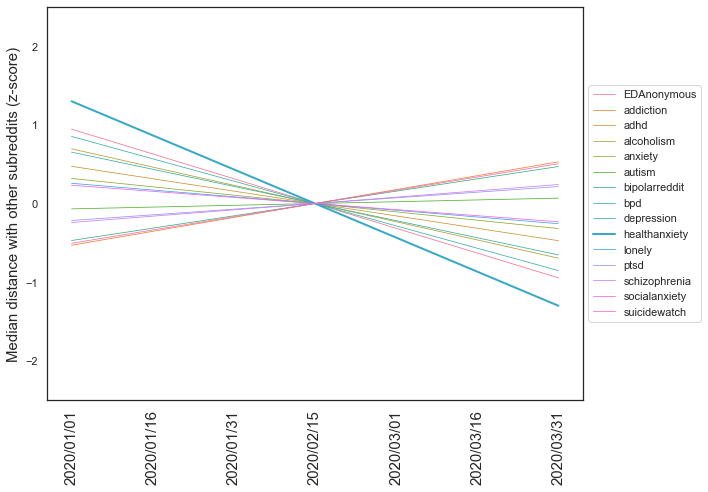

In [337]:
df = pd.DataFrame(median_percentiles)
df['timesteps'] = timesteps

from statsmodels.stats.multitest import multipletests
from scipy.interpolate import make_interp_spline, BSpline

correlations_mean = []

# color = 'husl' #hls husl
palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
sns.set(style='white', rc={'figure.figsize':(10,7)}, font_scale =1, palette=sns.color_palette("husl", 15))
pvals = []
fig, ax1 = plt.subplots()
for sr in subreddits:
    x = np.array(df.timesteps)
    x_digits = np.array(range(len(x)))
    y = np.array(df[sr])
    y = zscore(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)
    pvals.append(p_value)

    if sr == 'healthanxiety':
        alpha = 1
        linewidth = 2    
    else:
        alpha = 1
        linewidth = 0.75    
    color_i = next(palette)
    y = x_digits*slope + intercept
    ax1.plot(x, y,alpha=alpha, linewidth=linewidth,label = sr, color=color_i)

ax1.set_xticks(ticks=x_digits)
ax1.set_xticklabels(x, rotation=90, fontsize=15)
plt.ylim((-2.5,2.5))


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Median distance with other subreddits (z-score)', fontsize=15)
# plt.xticks(rotation=90)
plt.tight_layout()


from statsmodels.stats.multitest import multipletests
print(pvals)
reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
print(reject, pvals_corrected)

plt.savefig(output_dir+'median_percentile_distance_lines', dpi=400)

In [ ]:
# # Percentiles with regards to 2019
# percentile_3D_by_timestep = []

# # for each timestep, obtain matrix of hausdorff distances      
# for timestep_df in results_i_dists_hausdorff:
#     # create empty matrix      
#     percentile_df = np.zeros(np.array(timestep_df).shape)
#     for row in range(timestep_df.shape[0]):
#         for col in range(timestep_df.shape[1]):
#             distance_2020 = np.array(timestep_df)[row,col]
#             distribution_2019 = dists_all[:,row,col]
#             percentile = stats.percentileofscore(distribution_2019, distance_2020)
#             percentile_df[row,col] = percentile
#     percentile_3D_by_timestep.append(percentile_df)    

# percentile_3D_by_timestep = np.array(percentile_3D_by_timestep)
    

## Output gif

In [61]:
filenames

['2020-01-16.png',
 'example_distance_distribution.png',
 '2020-01-01.png',
 'y_timesteps.npy',
 'median_percentile_distance.png',
 'median_percentile_distance_lines.png',
 '2020-03-01.png',
 'run_1300_umap_gs_params_scores.csv',
 '2020-03-16.png',
 'percentile_all.png',
 'run_1300_umap_gs_centers.npy',
 'X_timesteps.npy',
 'run_1300_umap_gs_dists.npy',
 '2020-03-31.png',
 'trends',
 '2020-01-31.png',
 'heatmap_dists.png',
 'distances_all.png',
 'median_percentile_distance_curves.png',
 '2020-02-15.png',
 'run_1300_umap_gs_dists_hausdorff.npy']

In [63]:
filenames = os.listdir(input_dir)
filenames = [n for n in filenames if '.png' in n and '2020' in n]
# images = []
# for filename in filenames:
#     images.append(imageio.imread(input_dir+filename))
# imageio.mimsave(input_dir+'supervised.gif', images)
import imageio
with imageio.get_writer(output_dir+'supervised.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(input_dir+filename)
        writer.append_data(image)